## 1.Описание проекта
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Необходимо обучить на этих данных модель для прогноза оттока клиентов.
Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:     
**Файл contract_new.csv**     
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

**Файл personal_new.csv**     
- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

**Файл internet_new.csv**     
- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

**Файл phone_new.csv**     
- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

**Файл phone_new.csv**     
- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.


Оператор предоставляет два основных типа услуг:     
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).    
Также доступны такие услуги:     
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).     
Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

## 2. Исследование данных

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import os

import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import sklearn
import phik

from catboost import CatBoostClassifier


from matplotlib.pyplot import rcParams, rcParamsDefault
from matplotlib import transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    roc_auc_score,
    ConfusionMatrixDisplay
)

from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV,
    cross_val_score
)

from sklearn.preprocessing import (
    OneHotEncoder, 
    MinMaxScaler,
    LabelEncoder
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import make_pipeline

from skimpy import clean_columns

In [6]:
# настроим параметры графиков
rcParams['figure.figsize'] = 7,4
%config InlineBackend.figure_format = 'svg'
factor = 0.8
default_dpi = rcParamsDefault['figure.dpi']
rcParams['figure.dpi'] = default_dpi * factor

In [7]:
# Создадим функцию для получения первичной информации по датасету.
def get_data_info(data):
    display(data.sample(3))
    display(data.info())
    display(data.describe(include='all'))
    display('Количество явных дубликатов:', data.duplicated().sum())

In [8]:
# функция для загрузки данных из локального файла или URL.
def load_data(local_path, url):
    try:
        if os.path.exists(local_path):
            data = pd.read_csv(local_path)
            print('Данные успешно загружены из локального файла.')
            return data
        else:
            print('Локальный файл не найден, загрузка с URL...')
            raise FileNotFoundError
    except Exception as e:
        print('Ошибка при загрузке данных из локального файла:', e)
    
    # Попытка загрузки из URL
    try:
        data = pd.read_csv(url)
        print('Данные успешно загружены из URL.')
        return data
    except Exception as e:
        print('Ошибка при загрузке данных из URL:', e)
        return None

### 2.1. файл contract_new.csv

In [10]:
contract_new= load_data('/Users/gulnaravolodina/Downloads/contract_new.csv', 
                 'https://code.s3.yandex.net/datasets/contract_new.csv')

Данные успешно загружены из локального файла.


In [11]:
get_data_info(contract_new)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1080,0301-KOBTQ,2017-06-01,No,Two year,Yes,Bank transfer (automatic),20.05,699.34
5429,9488-FVZCC,2014-02-01,2016-07-01,Two year,Yes,Bank transfer (automatic),79.50,2305.5
1711,9964-WBQDJ,2014-03-01,No,Two year,Yes,Credit card (automatic),24.40,1749.72


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


'Количество явных дубликатов:'

0

In [12]:
# сделаем сustomerID индексом
contract= contract_new.set_index('customerID').copy()

In [13]:
# переименуем названия признаков в соответствии с синтаксисом.
contract= clean_columns(contract, case = 'camel')

In [14]:
contract['beginDate']=pd.to_datetime(contract['beginDate'])

In [15]:
#посмотрим уникальные значения в датасете
[{i: list(contract[i].unique())} for i in contract[['type','paperlessBilling','paymentMethod']]]

[{'type': ['Month-to-month', 'One year', 'Two year']},
 {'paperlessBilling': ['Yes', 'No']},
 {'paymentMethod': ['Electronic check',
   'Mailed check',
   'Bank transfer (automatic)',
   'Credit card (automatic)']}]

In [16]:
# изменим значения в соответствии с синтаксисом.
contract['type']= contract['type'].replace({'Month-to-month':'month', 'One year': 'one_year' , 'Two year': 'two_year'})

In [17]:
contract['paymentMethod']= contract['paymentMethod'].replace({'Electronic check':'e_check','Mailed check':'m_check', 
                                                             'Bank transfer (automatic)':'bank_auto','Credit card (automatic)':'card_auto'})

In [18]:
contract.sample()

,beginDate,endDate,type,paperlessBilling,paymentMethod,monthlyCharges,totalCharges
customerID,,,,,,,
0942-KOWSM,2017-08-01,No,two_year,No,bank_auto,80.8,2545.2


#### Тип данных столбцов (кроме endDate	и totalCharges) соответствует значениям, пропусков и опечаток в данных нет

### 2.2. файл personal_new.csv

In [21]:
personal_new= load_data('/Users/gulnaravolodina/Downloads/personal_new.csv', 
                 'https://code.s3.yandex.net/datasets/personal_new.csv')

Данные успешно загружены из локального файла.


In [22]:
get_data_info(personal_new)

,customerID,gender,SeniorCitizen,Partner,Dependents
5341,2982-IHMFT,Female,1,No,No
1544,3794-NFNCH,Male,0,Yes,No
616,6464-KEXXH,Male,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


'Количество явных дубликатов:'

0

In [23]:
# сделаем сustomerID индексом
personal= personal_new.set_index('customerID').copy()

In [24]:
personal = clean_columns(personal, case = 'camel')

In [25]:
#посмотрим уникальные значения в датасете
[{i: list(personal[i].unique())} for i in personal[['gender', 'seniorCitizen','partner','dependents']]]

[{'gender': ['Female', 'Male']},
 {'seniorCitizen': [0, 1]},
 {'partner': ['Yes', 'No']},
 {'dependents': ['No', 'Yes']}]

In [26]:
personal.sample()

,gender,seniorCitizen,partner,dependents
customerID,,,,
3621-CEOVK,Female,1,Yes,No


#### Тип данных столбцов соответствует значениям, пропусков и опечаток в данных нет

### 2.3. файл internet_new.csv

In [29]:
internet_new= load_data('/Users/gulnaravolodina/Downloads/internet_new.csv', 
                 'https://code.s3.yandex.net/datasets/internet_new.csv')

Данные успешно загружены из локального файла.


In [30]:
get_data_info(internet_new)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5502,8775-CEBBJ,DSL,No,No,No,No,No,No
4024,5840-NVDCG,DSL,Yes,Yes,No,Yes,No,Yes
1519,4587-NUKOX,Fiber optic,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


'Количество явных дубликатов:'

0

In [31]:
internet= internet_new.set_index('customerID').copy()

In [32]:
internet = clean_columns(internet, case = 'camel')

In [33]:
internet.sample()

,internetService,onlineSecurity,onlineBackup,deviceProtection,techSupport,streamingTv,streamingMovies
customerID,,,,,,,
9919-FZDED,DSL,Yes,Yes,Yes,No,Yes,Yes


In [34]:
#посмотрим уникальные значения в датасете
[{i: list(internet[i].unique())} for i in internet[['internetService', 'onlineSecurity','onlineBackup','deviceProtection',
                                                   'techSupport', 'streamingTv', 'streamingMovies']]]

[{'internetService': ['DSL', 'Fiber optic']},
 {'onlineSecurity': ['No', 'Yes']},
 {'onlineBackup': ['Yes', 'No']},
 {'deviceProtection': ['No', 'Yes']},
 {'techSupport': ['No', 'Yes']},
 {'streamingTv': ['No', 'Yes']},
 {'streamingMovies': ['No', 'Yes']}]

#### Тип данных столбцов соответствует значениям, пропусков и опечаток в данных нет

### 2.4. файл phone_new.csv

In [37]:
phone_new= load_data('/Users/gulnaravolodina/Downloads/phone_new.csv', 
                 'https://code.s3.yandex.net/datasets/phone_new.csv')

Данные успешно загружены из локального файла.


In [38]:
get_data_info(phone_new)

,customerID,MultipleLines
5795,2101-RANCD,Yes
3454,7868-BGSZA,Yes
1732,0754-EEBDC,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


'Количество явных дубликатов:'

0

In [39]:
phone= phone_new.set_index('customerID').copy()

In [40]:
# переименуем названия признаков в соответствии с синтаксисом
phone = clean_columns(phone, case = 'camel')

In [41]:
phone.sample()

,multipleLines
customerID,
7508-MYBOG,Yes


In [42]:
phone['multipleLines'].unique()

array(['No', 'Yes'], dtype=object)

#### Тип данных столбцов соответствует значениям, пропусков и опечаток в данных нет

## Выводы по предварительному исследованию данных
Было получено 4 датасета.
Во всех датасетах названия столбцов были изменены в соответствии с синтаксисом.
Явные дубликаты не обнаружены.
В датасете contract тип данных в столбце beginDate изменен на тип datetime.
Данные в признаках paymentMethod и type датасета contract изменены в соответствии с синтаксисом.

## 3. Исследование объединеного датасета

### 3.1. Обработка данных

In [47]:
# объединим первые 2 датасета
df_1 = contract.merge(personal, right_index=True, left_index=True)
df_1.sample()

,beginDate,endDate,type,paperlessBilling,paymentMethod,monthlyCharges,totalCharges,gender,seniorCitizen,partner,dependents
customerID,,,,,,,,,,,
3082-WQRVY,2018-12-01,No,one_year,No,m_check,19.65,283.35,Male,1,Yes,No


In [48]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   beginDate         7043 non-null   datetime64[ns]
 1   endDate           7043 non-null   object        
 2   type              7043 non-null   object        
 3   paperlessBilling  7043 non-null   object        
 4   paymentMethod     7043 non-null   object        
 5   monthlyCharges    7043 non-null   float64       
 6   totalCharges      7043 non-null   object        
 7   gender            7043 non-null   object        
 8   seniorCitizen     7043 non-null   int64         
 9   partner           7043 non-null   object        
 10  dependents        7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 918.3+ KB


In [49]:
# добавим третий, все значения
df_2 = df_1.merge(internet, on = 'customerID', how='outer')
df_2.sample()

,beginDate,endDate,type,paperlessBilling,paymentMethod,monthlyCharges,totalCharges,gender,seniorCitizen,partner,dependents,internetService,onlineSecurity,onlineBackup,deviceProtection,techSupport,streamingTv,streamingMovies
customerID,,,,,,,,,,,,,,,,,,
2740-JFBOK,2019-04-01,No,month,Yes,e_check,24.0,252.0,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   beginDate         7043 non-null   datetime64[ns]
 1   endDate           7043 non-null   object        
 2   type              7043 non-null   object        
 3   paperlessBilling  7043 non-null   object        
 4   paymentMethod     7043 non-null   object        
 5   monthlyCharges    7043 non-null   float64       
 6   totalCharges      7043 non-null   object        
 7   gender            7043 non-null   object        
 8   seniorCitizen     7043 non-null   int64         
 9   partner           7043 non-null   object        
 10  dependents        7043 non-null   object        
 11  internetService   5517 non-null   object        
 12  onlineSecurity    5517 non-null   object        
 13  onlineBackup      5517 non-null   object        
 14  deviceProtecti

In [51]:
# четвертый, все значения
df = df_2.merge(phone, on = 'customerID', how='outer')
df.sample()

,beginDate,endDate,type,paperlessBilling,paymentMethod,monthlyCharges,totalCharges,gender,seniorCitizen,partner,dependents,internetService,onlineSecurity,onlineBackup,deviceProtection,techSupport,streamingTv,streamingMovies,multipleLines
customerID,,,,,,,,,,,,,,,,,,,
2580-ASVVY,2017-01-01,No,two_year,No,e_check,45.4,1679.8,Female,0,Yes,No,DSL,Yes,No,No,Yes,Yes,No,NaN


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   beginDate         7043 non-null   datetime64[ns]
 1   endDate           7043 non-null   object        
 2   type              7043 non-null   object        
 3   paperlessBilling  7043 non-null   object        
 4   paymentMethod     7043 non-null   object        
 5   monthlyCharges    7043 non-null   float64       
 6   totalCharges      7043 non-null   object        
 7   gender            7043 non-null   object        
 8   seniorCitizen     7043 non-null   int64         
 9   partner           7043 non-null   object        
 10  dependents        7043 non-null   object        
 11  internetService   5517 non-null   object        
 12  onlineSecurity    5517 non-null   object        
 13  onlineBackup      5517 non-null   object        
 14  deviceProtecti

В итоговом датасете 18 признаков, есть пропущенные значения, тип данных в столбцах не соответствует значениям.

In [54]:
# изменим все буквы в значениях на строковые
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [55]:
df.sample()

,beginDate,endDate,type,paperlessBilling,paymentMethod,monthlyCharges,totalCharges,gender,seniorCitizen,partner,dependents,internetService,onlineSecurity,onlineBackup,deviceProtection,techSupport,streamingTv,streamingMovies,multipleLines
customerID,,,,,,,,,,,,,,,,,,,
4817-VYYWS,2017-04-01,2019-06-01,month,yes,e_check,100.2,2631.25,female,0,no,no,fiber optic,no,yes,no,no,yes,yes,yes


In [56]:
# посмотрим объем пропущенных значений
pd.DataFrame(df.isna().sum()/len(df) * 100)

,0
beginDate,0.000000
endDate,0.000000
type,0.000000
paperlessBilling,0.000000
paymentMethod,0.000000
monthlyCharges,0.000000
totalCharges,0.000000
gender,0.000000
seniorCitizen,0.000000
partner,0.000000


Пропущенные значения нельзя игнорировать, а также удалять строки с ними. Принято решение заполнить их «заглушками».

In [58]:
# создадим столбец с датой окончания контракта / датой среза
df['date'] = df['endDate']
df.insert(2, 'date', df.pop('date'))
df['date']= df['date'].replace({'no':'2020-02-01'})
df['date'] = pd.to_datetime(df['date'])

In [59]:
df.sample()

,beginDate,endDate,date,type,paperlessBilling,paymentMethod,monthlyCharges,totalCharges,gender,seniorCitizen,partner,dependents,internetService,onlineSecurity,onlineBackup,deviceProtection,techSupport,streamingTv,streamingMovies,multipleLines
customerID,,,,,,,,,,,,,,,,,,,,
0397-GZBBC,2014-12-01,2017-12-01,2017-12-01,month,yes,bank_auto,93.85,3648.89,male,1,yes,no,fiber optic,no,no,no,no,yes,yes,yes


In [60]:
# создадим новый признак, посчитаем длительность контракта с пользователем (в днях)
df['contractDuration'] = (df['date'] - df['beginDate']).dt.days
df.insert(3, 'contractDuration', df.pop('contractDuration'))

In [61]:
df.sample()

,beginDate,endDate,date,contractDuration,type,paperlessBilling,paymentMethod,monthlyCharges,totalCharges,gender,...,partner,dependents,internetService,onlineSecurity,onlineBackup,deviceProtection,techSupport,streamingTv,streamingMovies,multipleLines
customerID,,,,,,,,,,,,,,,,,,,,,
0365-BZUWY,2018-09-01,no,2020-02-01,518,month,yes,e_check,102.55,1813.08,male,...,yes,no,fiber optic,no,yes,yes,no,yes,yes,yes


In [62]:
# переведем ряд признаков в бинарные
df[['paperlessBilling', 'partner', 'dependents']] = df[['paperlessBilling', 'partner', 
                                                        'dependents']].replace({'yes': 1, 'no': 0}).apply(pd.to_numeric)

In [63]:
# заменим пропущенные значения в ряде признаков на unknown
df.loc[:, ['multipleLines', 'streamingMovies', 'streamingTv', 'techSupport', 'deviceProtection', 'onlineBackup', 'onlineSecurity','internetService']] = df[['multipleLines', 'streamingMovies', 'streamingTv', 'techSupport', 'deviceProtection', 'onlineBackup', 'onlineSecurity',
         'internetService']] = df.loc[:, ['multipleLines', 'streamingMovies', 'streamingTv', 'techSupport', 'deviceProtection', 'onlineBackup', 'onlineSecurity','internetService']] = df[['multipleLines', 'streamingMovies', 'streamingTv', 'techSupport', 'deviceProtection', 'onlineBackup', 'onlineSecurity',
         'internetService']].fillna('unknown')
df.multipleLines.unique()

array(['unknown', 'no', 'yes'], dtype=object)

In [64]:
df['total_services'] = df.iloc[:, 1:].apply(lambda row: sum(1 for val in row if val in {'yes', 'dsl', 'fiber_optic'}), axis=1)

In [65]:
df.sample()

,beginDate,endDate,date,contractDuration,type,paperlessBilling,paymentMethod,monthlyCharges,totalCharges,gender,...,dependents,internetService,onlineSecurity,onlineBackup,deviceProtection,techSupport,streamingTv,streamingMovies,multipleLines,total_services
customerID,,,,,,,,,,,,,,,,,,,,,
2235-DWLJU,2019-08-01,no,2020-02-01,184,month,1,e_check,44.4,266.4,female,...,0,dsl,no,no,no,no,yes,yes,unknown,3


In [66]:
# посмотрим пустые значения в признаке totalCharges
df.loc[df['totalCharges']== ' ']

,beginDate,endDate,date,contractDuration,type,paperlessBilling,paymentMethod,monthlyCharges,totalCharges,gender,...,dependents,internetService,onlineSecurity,onlineBackup,deviceProtection,techSupport,streamingTv,streamingMovies,multipleLines,total_services
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,no,2020-02-01,0,two_year,1,bank_auto,52.55,,female,...,1,dsl,yes,no,yes,yes,yes,no,unknown,5
3115-CZMZD,2020-02-01,no,2020-02-01,0,two_year,0,m_check,20.25,,male,...,1,unknown,unknown,unknown,unknown,unknown,unknown,unknown,no,0
5709-LVOEQ,2020-02-01,no,2020-02-01,0,two_year,0,m_check,80.85,,female,...,1,dsl,yes,yes,yes,no,yes,yes,no,6
4367-NUYAO,2020-02-01,no,2020-02-01,0,two_year,0,m_check,25.75,,male,...,1,unknown,unknown,unknown,unknown,unknown,unknown,unknown,yes,1
1371-DWPAZ,2020-02-01,no,2020-02-01,0,two_year,0,card_auto,56.05,,female,...,1,dsl,yes,yes,yes,yes,yes,no,unknown,6
7644-OMVMY,2020-02-01,no,2020-02-01,0,two_year,0,m_check,19.85,,male,...,1,unknown,unknown,unknown,unknown,unknown,unknown,unknown,no,0
3213-VVOLG,2020-02-01,no,2020-02-01,0,two_year,0,m_check,25.35,,male,...,1,unknown,unknown,unknown,unknown,unknown,unknown,unknown,yes,1
2520-SGTTA,2020-02-01,no,2020-02-01,0,two_year,0,m_check,20.00,,female,...,1,unknown,unknown,unknown,unknown,unknown,unknown,unknown,no,0
2923-ARZLG,2020-02-01,no,2020-02-01,0,one_year,1,m_check,19.70,,male,...,1,unknown,unknown,unknown,unknown,unknown,unknown,unknown,no,0


Пропущенные значения в признаке totalCharges обусловлены открытием контракта в день среза данных. Заменим значения на 0, так как нам неизвестно, оплатил ли абонент уже подписку или нет

In [68]:
df['totalCharges']= df['totalCharges'].replace({' ': 0}).astype(float)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   beginDate         7043 non-null   datetime64[ns]
 1   endDate           7043 non-null   object        
 2   date              7043 non-null   datetime64[ns]
 3   contractDuration  7043 non-null   int64         
 4   type              7043 non-null   object        
 5   paperlessBilling  7043 non-null   int64         
 6   paymentMethod     7043 non-null   object        
 7   monthlyCharges    7043 non-null   float64       
 8   totalCharges      7043 non-null   float64       
 9   gender            7043 non-null   object        
 10  seniorCitizen     7043 non-null   int64         
 11  partner           7043 non-null   int64         
 12  dependents        7043 non-null   int64         
 13  internetService   7043 non-null   object        
 14  onlineSecurity

Изменим целевой признак endDate на категориальный, где no - клиент остался на контракте, yes - клиент ушел

In [71]:
# Преобразуем столбец в тип datetime
def replace_dates(val):
    try:
        pd.to_datetime(val)  
        return 'yes'         
    except ValueError:
        return val           

# Применяем функцию ко всем значениям в столбце
df['endDate'] = df['endDate'].apply(replace_dates)

df.sample(5)

,beginDate,endDate,date,contractDuration,type,paperlessBilling,paymentMethod,monthlyCharges,totalCharges,gender,...,dependents,internetService,onlineSecurity,onlineBackup,deviceProtection,techSupport,streamingTv,streamingMovies,multipleLines,total_services
customerID,,,,,,,,,,,,,,,,,,,,,
5054-IEXZT,2019-11-01,no,2020-02-01,92,month,1,e_check,75.35,226.05,male,...,1,fiber optic,no,yes,no,no,no,no,no,1
9079-YEXQJ,2015-07-01,yes,2019-03-01,1339,month,0,e_check,111.10,5181.70,female,...,0,fiber optic,no,yes,yes,yes,yes,yes,yes,6
5837-LXSDN,2018-05-01,no,2020-02-01,641,one_year,1,card_auto,58.85,1235.85,female,...,1,dsl,no,yes,no,no,yes,no,no,3
9787-XVQIU,2019-10-01,no,2020-02-01,123,month,1,e_check,75.30,301.20,male,...,0,fiber optic,no,no,no,no,no,no,yes,1
7820-ZYGNY,2014-11-01,yes,2017-08-01,1004,one_year,0,card_auto,90.45,2984.85,male,...,0,fiber optic,no,yes,no,no,no,yes,yes,3


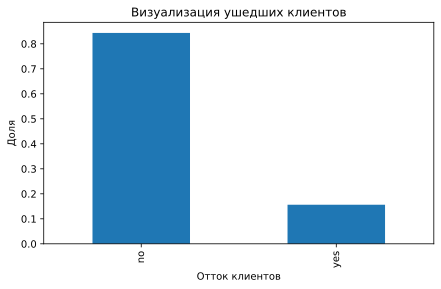

In [72]:
# посмотрим распределение целевого признака
df.endDate.value_counts(normalize=True).plot(kind='bar') 
plt.xlabel('Отток клиентов')
plt.ylabel('Доля')
plt.title('Визуализация ушедших клиентов')
plt.show()

Целевой признак несбалансирован, необходимо это учесть при подготовки модели

### 3.2. Визуализация

In [75]:
# создадим функцию, которая будет отображать сразу 2 графика
def create_double_pie(data1, data2, title1, title2):
    sns.set_style("darkgrid")
    
    # Создаем фигуру и оси для двух круговых диаграмм
    fig, axs = plt.subplots(1, 2, figsize=(10, 7)) 

    # Первая круговая диаграмма
    total1 = sum(data1)  
    wedges1, texts1, autotexts1 = axs[0].pie(data1, labels=data1.index, autopct='%1.1f%%', 
                                             startangle=90, colors=sns.color_palette("pastel", len(data1)))
    
    for t in autotexts1:
        t.set_size(10)
        t.set_color('black')
        
    axs[0].set_title(title1, fontsize=12)

    # Вторая круговая диаграмма
    total2 = sum(data2)  #
    wedges2, texts2, autotexts2 = axs[1].pie(data2, labels=data2.index, autopct='%1.1f%%', 
                                             startangle=90, colors=sns.color_palette("pastel", len(data2)))
    
    for t in autotexts2:
        t.set_size(10)
        t.set_color('black')
        
    axs[1].set_title(title2, fontsize=12)

    plt.tight_layout()
    plt.show()

In [76]:
# создадим функию, подсчитывающую долю ушедших клиентов от всей базы с учетом признака
def calculate_shares(df, quit, column):

    all_count = df[column].value_counts()
    quit_count = quit[column].value_counts()

    for i in quit_count.index:
        quit_count[i] /= all_count[i]

    return quit_count*100

In [77]:
# для исследования посмотрим отдельно распределение признаков среди всех абонентов и среди ушедших
quit = df[df['endDate'] == 'yes']
quit.shape

(1101, 22)

In [78]:
# функция для построения распределения значений на основе данных в DataFrame
def create_plot(df, x_col, xname, title):


    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    sns.kdeplot(data=df, x=x_col, hue= 'endDate', common_norm=False, fill=True,
                palette={'no': 'green', 'yes': 'red'}, alpha=0.5)
    plt.title(title)
    plt.xlabel(xname)
    plt.ylabel('Плотность вероятности')
    plt.legend(title='статус клиентов', labels=['Ушли (yes)', 'Остались (no)'])
    plt.show()

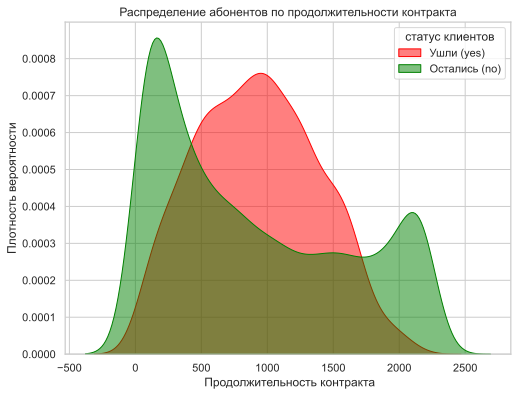

In [79]:
create_plot(df, 'contractDuration',' Продолжительность контракта', 'Распределение абонентов по продолжительности контракта')


Согласно графику, видно, что у компании появилось большое количество новых абонентов, которые спустя непродолжительное время начинают разрывать контракты. После 1 года пользования услугами компании количество ушедших клиентов больше, чем количество оставшихся. Те, кто пользуется услугами компании свыше 5 лет, практически не меняют оператора и остаются.

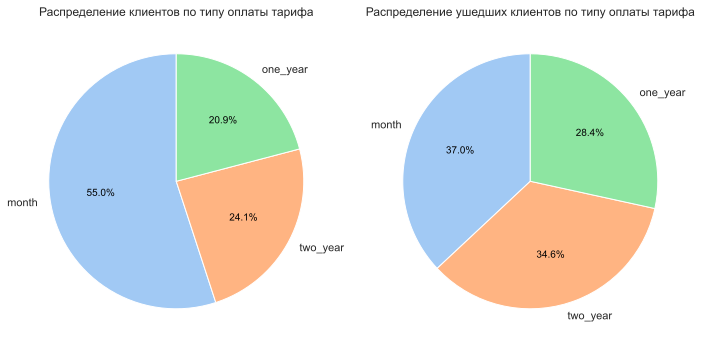

In [81]:
create_double_pie(df.type.value_counts(), quit.type.value_counts(), 
                      'Распределение клиентов по типу оплаты тарифа', 'Распределение ушедших клиентов по типу оплаты тарифа')

In [82]:
# посмотрим долю ушедших клиентов в зависимости от типа оплаты
calculate_shares(df, quit, 'type')

month       10.503226
two_year    22.477876
one_year    21.249151
Name: type, dtype: float64

Отмечается, что среди ушедших клиентов больше тех, кто оплачивал ежемесячно (это логично). Интересно, что доля клиентов, кто оплачивал 1 раз в два года, выше и практически соотносится с ежемесячной подпиской, что можно объяснить недовольством клиентов тарифной политикой и/или негибкостью компании при продлении подписки (например, отсутствие скидки для лояльных клиентов или существенным увеличением за 2 года стоимости подписки). Также больше всего потеряла компания клиентов, которые оплачивали двухгодовалую подписку (22.5%)

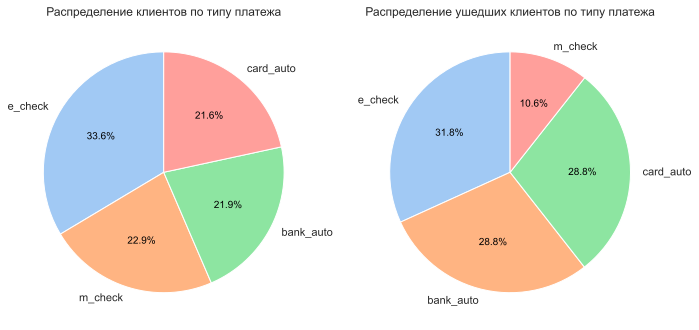

In [84]:
create_double_pie(df.paymentMethod.value_counts(), quit.paymentMethod.value_counts(), 
                      'Распределение клиентов по типу платежа', 'Распределение ушедших клиентов по типу платежа')

In [85]:
# посмотрим долю ушедших клиентов в зависимости от метода оплаты
calculate_shares(df, quit, 'paymentMethod')

e_check      14.799154
bank_auto    20.531088
card_auto    20.827858
m_check       7.258065
Name: paymentMethod, dtype: float64

Интересно, что среди ушедших клиентов выше доля автоматических платежей (bank_auto, card_auto), чем среди всех клиентов компании. Это можно объяснить тем, что эти клиенты технологичнее и мониторят условия других операторов связи.
Меньше всего уходят клиенты, которые оплачивают услуги с помощью почтового чека, что можно объяснить либо возрастом абонента, либо определенным регионом, где проживает абонент, в котором нет доступа к банковским услугам.

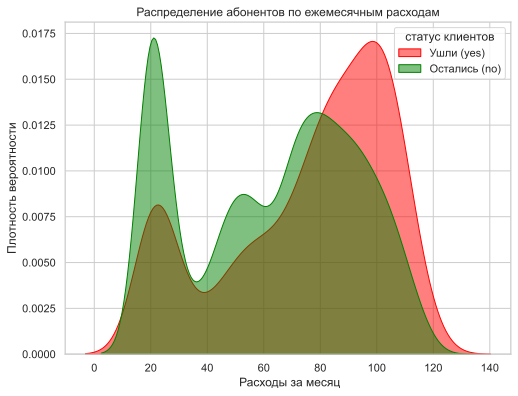

In [87]:
create_plot(df, 'monthlyCharges',' Расходы за месяц', 'Распределение абонентов по ежемесячным расходам')

Согласно распределению, можно сделать вывод, что больше всего оттекает клиентов среди тех, кто оформил более дорогую подписку, стоимостью свыше 80 уе. При этом доля клиентов с минимальной стоимостью подписки растет.

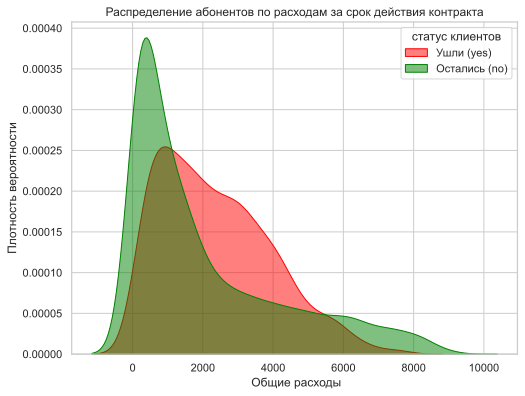

In [89]:
create_plot(df, 'totalCharges',' Общие расходы', 'Распределение абонентов по расходам за срок действия контракта')

Число ушедших клиентов с общими тратами от 1500 уе выше, чем число клиентов, которые остались с компанией. Это возможно объяснить активным привлечением новых абонентов и снижением тарифов

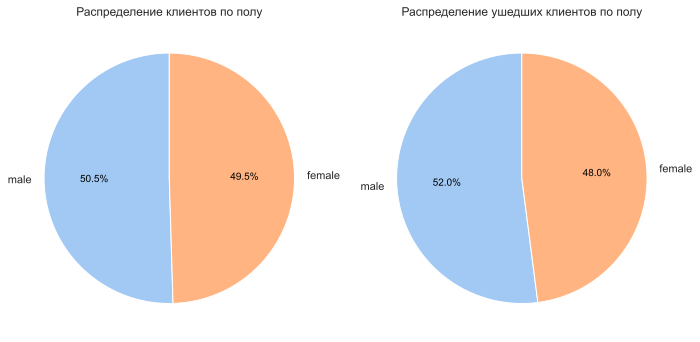

In [91]:
create_double_pie(df.gender.value_counts(), quit.gender.value_counts(), 
                      'Распределение клиентов по полу', 'Распределение ушедших клиентов по полу')

In [92]:
# посмотрим долю ушедших клиентов в зависимости от пола
calculate_shares(df, quit, 'gender')

male      16.118143
female    15.137615
Name: gender, dtype: float64

Распределение ушедших клиентов по полу практически соответствует структуре клиентов компании

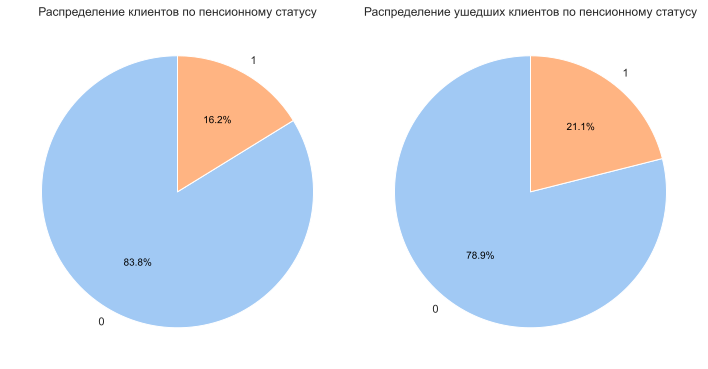

In [94]:
create_double_pie(df.seniorCitizen.value_counts(), quit.seniorCitizen.value_counts(), 
                      'Распределение клиентов по пенсионному статусу', 'Распределение ушедших клиентов по пенсионному статусу')

In [95]:
# посмотрим долю ушедших клиентов в зависимости от пенсионного статуса
calculate_shares(df, quit, 'seniorCitizen')

0    14.726318
1    20.315236
Name: seniorCitizen, dtype: float64

Среди ушедших клиентов доля пенсионеров выше, чем более молодого поколения. Это можно объяснить как естественной убылью абонентов (демографические факторы, переезд к родственникам), так и сменой политики компании в части привлечения «идеального» клиента.

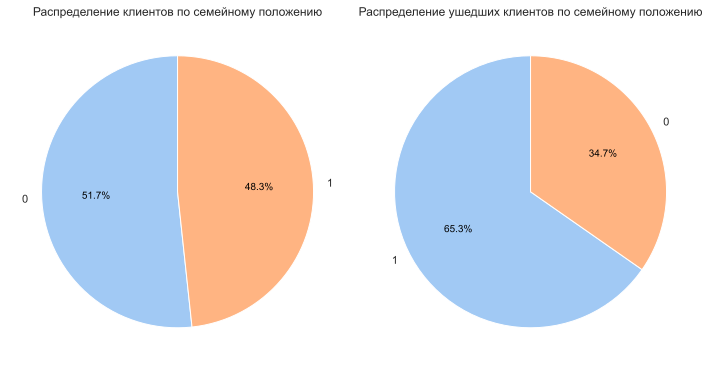

In [97]:
create_double_pie(df.partner.value_counts(), quit.partner.value_counts(), 
                      'Распределение клиентов по семейному положению', 'Распределение ушедших клиентов по семейному положению')

In [98]:
# посмотрим долю ушедших клиентов в зависимости от семейного положения
calculate_shares(df, quit, 'partner')

1    21.134627
0    10.491623
Name: partner, dtype: float64

Среди ушедших клиентов выше доля семейных пар, чем одиноких людей. Можно объяснить изменением количества членов семьи и, следовательно, интересов семьи, либо необходимостью сокращать свои расходы, изменением места жительства и т/д. 

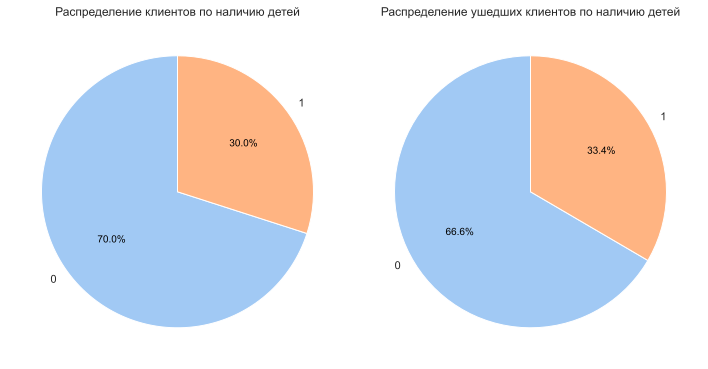

In [100]:
create_double_pie(df.dependents.value_counts(), quit.dependents.value_counts(), 
                      'Распределение клиентов по наличию детей', 'Распределение ушедших клиентов по наличию детей')

In [101]:
# посмотрим долю ушедших клиентов в зависимости от наличия детей
calculate_shares(df, quit, 'dependents')

0    14.859112
1    17.440758
Name: dependents, dtype: float64

Доля ушедших клиентов с детьми выше, чем доля клиентов без детей. Как и в случае с семейным положением, это можно объяснить необходимостью сокращать свои расходы, изменением места жительства, либо отсутствием необходимых сервисов (детского контента / блокировкой взрослого контента и т/д/).

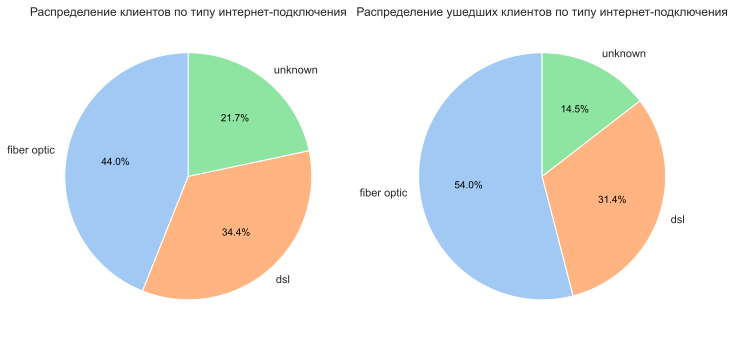

In [103]:
create_double_pie(df.internetService.value_counts(), quit.internetService.value_counts(), 
                      'Распределение клиентов по типу интернет-подключения', 'Распределение ушедших клиентов по типу интернет-подключения')

In [104]:
# посмотрим долю ушедших клиентов в зависимости от типа интернет-подключения
calculate_shares(df, quit, 'internetService')

fiber optic    19.218346
dsl            14.291615
unknown        10.484928
Name: internetService, dtype: float64

Среди ушедших клиентов выше доля клиентов, которые были подключены через оптоволокно. Возможно, это связано с низкой скоростью передачи данных либо появлением конкурента, который в дальнейшем проложил линию и предложил сниженные тарифы.

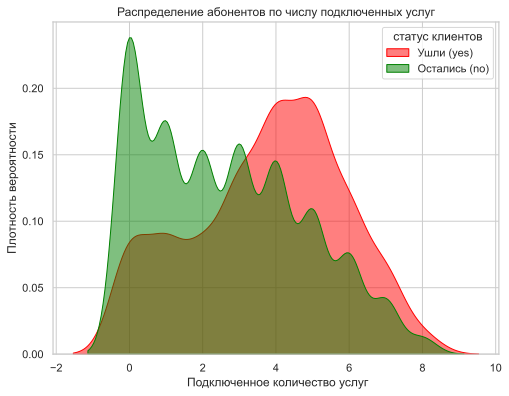

In [106]:
create_plot(df, 'total_services',' Подключенное количество услуг', 'Распределение абонентов по числу подключенных услуг')

In [107]:
# посмотрим долю ушедших клиентов в зависимости от количества подключенных услуг
calculate_shares(df, quit, 'total_services')

5    27.318296
4    21.377913
3    15.276382
6    24.344569
0     7.339450
1     9.677419
2    10.188261
7    25.418060
8    21.839080
Name: total_services, dtype: float64

Среди клиентов, у которых подключено от трех услуг, выше доля ушедших, чем у тех, кто подключил 1-2 услуги или не подключил ни одной. Это можно объяснить либо неудовлетворением клиентов от услуг (высокая стоимость услуг по отдельности, низкое качество)

In [109]:
# построим матрицу корреляции phik
df_types = {'beginDate':'date',
            'endDate': 'categorical',
            'date': 'date',
            'contractDuration': 'discrete',
            'paperlessBilling':'discrete', 
            'paymentMethod':'categorical',
            'monthlyCharges':'interval',
           'totalCharges':'interval',
            'gender':'categorical',
            'seniorCitizen':'discrete',
            'partner':'discrete',
            'dependents':'discrete',
            'internetService':'categorical',
           'onlineSecurity':'categorical',
           'onlineBackup':'categorical',
           'deviceProtection':'categorical',
           'techSupport':'categorical',
           'techSupport':'categorical',
           'streamingMovies':'categorical',
           'multipleLines':'categorical',
           'total_services': 'discrete'}

interval_cols = [col for col, v in df_types.items() if v=='interval' and col in df.columns]

In [110]:
сorrelation_matrix = df.phik_matrix(interval_cols=interval_cols, bins = 5)
display(сorrelation_matrix)

,beginDate,endDate,date,contractDuration,type,paperlessBilling,paymentMethod,monthlyCharges,totalCharges,gender,...,dependents,internetService,onlineSecurity,onlineBackup,deviceProtection,techSupport,streamingTv,streamingMovies,multipleLines,total_services
beginDate,1.000000,0.450254,0.548313,0.999529,0.766249,0.081447,0.456389,0.397116,0.769654,0.011268,...,0.208564,0.192197,0.460712,0.496176,0.502422,0.455418,0.419599,0.431137,0.468035,0.565714
endDate,0.450254,1.000000,1.000000,0.928032,0.094015,0.083398,0.214832,0.140620,0.167033,0.008581,...,0.046871,0.056621,0.058659,0.089704,0.085608,0.051537,0.078545,0.086577,0.105101,0.198317
date,0.548313,1.000000,1.000000,0.983337,0.285429,0.062936,0.169262,0.200660,0.239908,0.018274,...,0.055518,0.117099,0.166235,0.236373,0.225828,0.150303,0.185980,0.199118,0.249504,0.261244
contractDuration,0.999529,0.928032,0.983337,1.000000,0.764608,0.078497,0.466171,0.409559,0.844895,0.000000,...,0.223641,0.213491,0.467733,0.491546,0.504889,0.460792,0.427421,0.441171,0.470666,0.561855
type,0.766249,0.094015,0.285429,0.764608,1.000000,0.106860,0.277462,0.238576,0.355613,0.000000,...,0.147680,0.505187,0.636884,0.581660,0.631531,0.671629,0.549564,0.553556,0.244410,0.667969
paperlessBilling,0.081447,0.083398,0.062936,0.078497,0.106860,1.000000,0.370495,0.286875,0.122624,0.000000,...,0.172593,0.231438,0.208320,0.195321,0.195687,0.200621,0.204717,0.202241,0.099953,0.263534
paymentMethod,0.456389,0.214832,0.169262,0.466171,0.277462,0.370495,1.000000,0.285340,0.215195,0.000000,...,0.224903,0.323886,0.315799,0.293413,0.297923,0.317713,0.284531,0.285525,0.174849,0.346850
monthlyCharges,0.397116,0.140620,0.200660,0.409559,0.238576,0.286875,0.285340,1.000000,0.744480,0.000000,...,0.100616,0.790972,0.667319,0.682584,0.695400,0.672465,0.738740,0.737906,0.483010,0.707533
totalCharges,0.769654,0.167033,0.239908,0.844895,0.355613,0.122624,0.215195,0.744480,1.000000,0.002826,...,0.032702,0.401964,0.424814,0.455080,0.461338,0.435301,0.460421,0.459347,0.357210,0.590469
gender,0.011268,0.008581,0.018274,0.000000,0.000000,0.000000,0.000000,0.000000,0.002826,1.000000,...,0.000000,0.000000,0.001460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


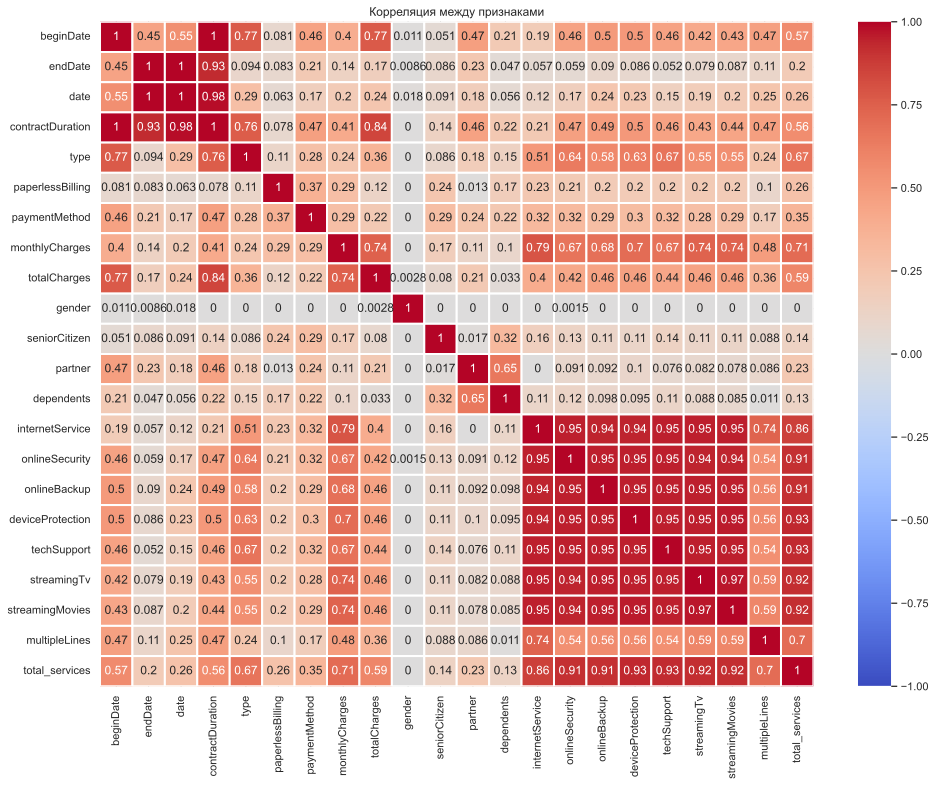

In [111]:
fig = plt.figure(figsize=(16, 12)) 
sns.heatmap(сorrelation_matrix, annot = True, fmt = '.2g', cmap = 'coolwarm', vmin = -1, center = 0, linewidths = 2)
plt.title('Корреляция между признаками')
plt.show()

Признак date высоко коррелирует с целевым признаком. А также высоко коррелируют между собой признаки по предоставляемым дополнительным услугам в части интернета. Уберем признаки с высокой корреляцией друг с другом, оставив только internetService и multipleLines как 2 основные услуги.

In [113]:
df_final = df.drop(['beginDate', 'date','onlineSecurity', 'onlineBackup', 
                    'deviceProtection', 'techSupport', 'streamingTv', 'streamingMovies'], axis =1)

In [114]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   endDate           7043 non-null   object 
 1   contractDuration  7043 non-null   int64  
 2   type              7043 non-null   object 
 3   paperlessBilling  7043 non-null   int64  
 4   paymentMethod     7043 non-null   object 
 5   monthlyCharges    7043 non-null   float64
 6   totalCharges      7043 non-null   float64
 7   gender            7043 non-null   object 
 8   seniorCitizen     7043 non-null   int64  
 9   partner           7043 non-null   int64  
 10  dependents        7043 non-null   int64  
 11  internetService   7043 non-null   object 
 12  multipleLines     7043 non-null   object 
 13  total_services    7043 non-null   int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 1.1+ MB


### Выводы, полученные после исследования данных.
Были объединены все 4 датасета с помощью merge, присоединяя все имеющиеся данные в них.     
Итоговый датасет df содержал пропуски, которые были заполнены с помощью «заглушки» unknown, так как   
Были созданы дополнительные признаки:
- «contractDuration», который рассчитывает длительность контракта в днях с момента заключения до даты окончания либо до даты среза 01.02.2020.
- «total_services», который подсчитывает количество услуг, которыми пользуется абонент. 
Признаки 'paperlessBilling', 'partner', 'dependents' были переведены в бинарные согласно значениям.    
В столбце 'totalCharges' были обнаружены пустые значения, которые заполнили 0, так как их причина в том, что дата начала контракта равна дате среза, и абонент еще не понес никаких расходов, тип данных сменили на float.
Целевой признак изменили на категориальный (yes/no). Целевой признак не сбалансирован, что необходимо учесть при построении модели.
Графики визуализации данных показывают следующее:
- У компании появилось большое количество новых абонентов, которые спустя непродолжительное время начинают разрывать контракты. После 1 года пользования услугами компании количество ушедших клиентов больше, чем количество оставшихся. Те, кто пользуется услугами компании свыше 5 лет, практически не меняют оператора и остаются.
- Отмечается, что среди ушедших клиентов больше тех, кто оплачивал ежемесячно (это логично). Интересно, что доля клиентов, кто оплачивал 1 раз в два года, выше и практически соотносится с ежемесячной подпиской, что можно объяснить недовольством клиентов тарифной политикой и/или негибкостью компании при продлении подписки (например, отсутствие скидки для лояльных клиентов или существенным увеличением за 2 года стоимости подписки). Также больше всего потеряла компания клиентов, которые оплачивали двухгодовалую подписку (22.5%).
- Интересно, что среди ушедших клиентов выше доля автоматических платежей (bank_auto, card_auto), чем среди всех клиентов компании. Это можно объяснить тем, что эти клиенты технологичнее и мониторят условия других операторов связи. Меньше всего уходят клиенты, которые оплачивают услуги с помощью почтового чека, что можно объяснить либо возрастом абонента, либо определенным регионом, где проживает абонент, в котором нет доступа к банковским услугам.
- Согласно распределению, можно сделать вывод, что больше всего оттекает клиентов среди тех, кто оформил более дорогую подписку, стоимостью свыше 80 уе. При этом доля клиентов с минимальной стоимостью подписки растет.
- Число ушедших клиентов с общими тратами от 1500 уе выше, чем число клиентов, которые остались с компанией. Это возможно объяснить активным привлечением новых абонентов и снижением тарифов.
- Среди ушедших клиентов доля пенсионеров выше, чем более молодого поколения. Это можно объяснить как естественной убылью абонентов (демографические факторы, переезд к родственникам), так и сменой политики компании в части привлечения «идеального» клиента.
- Среди ушедших клиентов выше доля семейных пар, чем одиноких людей. Можно объяснить изменением количества членов семьи и, следовательно, интересов семьи, либо необходимостью сокращать свои расходы, изменением места жительства и т.д.
- Доля ушедших клиентов с детьми выше, чем доля клиентов без детей. Как и в случае с семейным положением, это можно объяснить необходимостью сокращать свои расходы, изменением места жительства, либо отсутствием необходимых сервисов (детского контента / блокировкой взрослого контента и т.д.).
- Среди ушедших клиентов выше доля клиентов, которые были подключены через оптоволокно. Возможно, это связано с низкой скоростью передачи данных либо появлением конкурента, который в дальнейшем проложил линию и предложил сниженные тарифы.
- Среди клиентов, у которых подключено от трех услуг, выше доля ушедших, чем у тех, кто подключил 1-2 услуги или не подключил ни одной. Это можно объяснить либо неудовлетворением клиентов от услуг (высокая стоимость услуг по отдельности, низкое качество).
Для принятия решения по окончательным признакам, подаваемым в модель, была построена матрица корреляции phi, которая показала, что признак date высоко коррелирует с целевым признаком. А также высоко коррелируют между собой признаки по предоставляемым дополнительным услугам в части интернета. Из итогового датасета были удалены признаки с высокой корреляцией друг с другом, оставив только internetService и multipleLines как 2 основные услуги.

## 4. Обучение модели

In [116]:
X = df_final.drop(['endDate'], axis = 1)
y = df_final['endDate']

In [117]:
# закодируем целевой признак
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [118]:
RANDOM_STATE = 130125

In [119]:
X_train, X_test, y_train, y_test = train_test_split(
 X, y_encoded, test_size=0.25, random_state=130125, stratify=y
)

X_train.shape, y_train.shape

((5282, 13), (5282,))

In [120]:
ohe_columns = [
    'paymentMethod',     
    'type', 
    'gender',
    'internetService',
    'multipleLines'
]

num_columns = ['contractDuration', 'paperlessBilling', 'monthlyCharges', 'totalCharges', 'seniorCitizen', 
               'partner', 'dependents', 'total_services'] 

In [121]:
ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

In [122]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns) 
    ], 
    remainder='passthrough')


In [123]:
best_models = {}
def train_single_model(model, params, model_name, results_df, best_models):

    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Используем RandomizedSearchCV для нахождения лучших гиперпараметров
    rz_search = RandomizedSearchCV(
    pipeline, 
    params, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    error_score='raise',
    refit=True
)

    # Обучаем модель
    rz_search.fit(X_train, y_train)   
    
    mean_fit_time = rz_search.cv_results_['mean_fit_time'][rz_search.best_index_]
    mean_score_time = rz_search.cv_results_['mean_score_time'][rz_search.best_index_]
    
    
    # Собираем результаты в виде словаря
    result = pd.DataFrame([{
        'model_name': model_name,
        'best_params': rz_search.best_params_,
        'roc_auc': rz_search.best_score_,
        'mean_fit_time': mean_fit_time,
        'mean_score_time': mean_score_time
    }])
    results_df = pd.concat([results_df, result], ignore_index=True)

    # Сохраняем лучшую модель в словарь
    best_models[model_name] = rz_search.best_estimator_

    # Выводим результаты
    print('Лучшая модель и её параметры:\n\n', rz_search.best_estimator_)
    print('Метрика лучшей модели на кросс-валидации:', rz_search.best_score_)

    return results_df, best_models

In [124]:
results_df = pd.DataFrame(columns=['model_name', 'roc_auc', 'mean_fit_time', 'mean_score_time'])

In [125]:
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced')
params = {
    'model__C': [i * 0.1 for i in range(1, 15)]
}
results_df, best_models_lr = train_single_model(model, params, 'LogisticRegression', results_df, best_models)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['paymentMethod', 'type',
                                                   'gender', 'internetService',
                                                   'multipleLines']),
                                                 ('num', MinMaxScaler(),
                                                  ['contractDuration',
                                                   'paperlessBillin

In [126]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)
params =  {
        'model__max_depth': range(1, 10),
        'model__min_samples_leaf': range(2, 20),
        'model__min_samples_split': range(2, 10)}

results_df, best_models_dtr = train_single_model(model, params, 'DecisionTreeClassifier', results_df, best_models)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['paymentMethod', 'type',
                                                   'gender', 'internetService',
                                                   'multipleLines']),
                                                 ('num', MinMaxScaler(),
                                                  ['contractDuration',
                                                   'paperlessBillin

In [127]:
model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)
params =  {
        'model__iterations': range(500, 1000),
        'model__learning_rate': np.arange(0.1, 0.3, 0.01),
        'model__depth': range(2, 10)}

results_df, best_models = train_single_model(model, params, 'CatBoostClassifier', results_df, best_models)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['paymentMethod', 'type',
                                                   'gender', 'internetService',
                                                   'multipleLines']),
                                                 ('num', MinMaxScaler(),
                                                  ['contractDuration',
                                                   'paperlessBillin

In [128]:
pd.set_option('display.max_columns', None)
print(results_df)

               model_name   roc_auc  mean_fit_time  mean_score_time  \
0      LogisticRegression  0.768562       0.059223         0.014975   
1  DecisionTreeClassifier  0.792952       0.113328         0.040372   
2      CatBoostClassifier  0.901011       1.390293         0.042633   

                                         best_params  
0                   {'model__C': 1.4000000000000001}  
1  {'model__min_samples_split': 9, 'model__min_sa...  
2  {'model__learning_rate': 0.12, 'model__iterati...  


In [129]:
# рассчитаем для тестовой выборке метрики лучшей модели
y_pred_mod = best_models['CatBoostClassifier'].predict(X_test)
y_pred_proba = best_models['CatBoostClassifier'].predict_proba(X_test)[:, 1] 

# вычисление метрик
roc_auc_test = roc_auc_score(y_test, y_pred_proba)
accuracy_test = accuracy_score(y_test, y_pred_mod)
print(f"ROC-AUC на тестовой выборке: {roc_auc_test:.4f}")
print(f"Accuracy на тестовой выборке: {accuracy_test:.4f}")

ROC-AUC на тестовой выборке: 0.9147
Accuracy на тестовой выборке: 0.9137


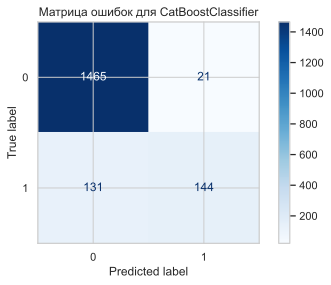

In [130]:
# Создание матрицы ошибок
cm = confusion_matrix(y_test, y_pred_mod)

# Визуализация матрицы ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_models['CatBoostClassifier'].classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Матрица ошибок для CatBoostClassifier')
plt.show()

Модель хорошо предсказывает клиентов, которые планируют остаться в компании (1474), но при этом пропустила 12 клиентов, которые она посчитала склонных к оттоку. Также модель ошиблась на 102 клиентах, предсказав из уход из компании, и при этом пропустила 173 клиента, которые готовы уйти, записав их в лояльные

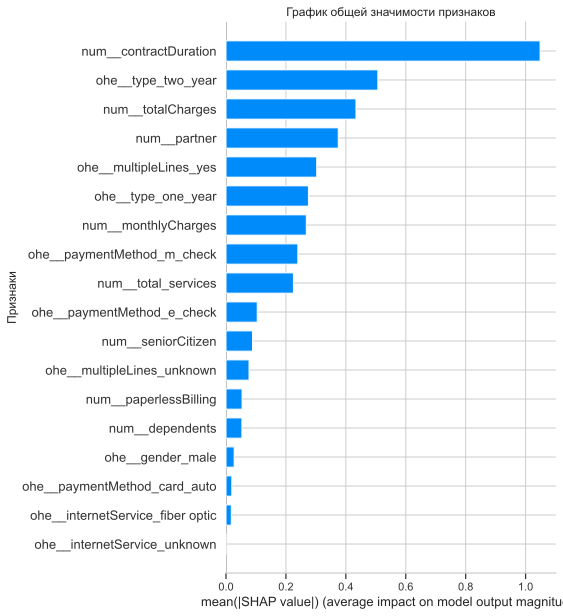

None

In [132]:
# создание explainer для CatBoostClassifier
catboost_model = best_models['CatBoostClassifier'].named_steps['preprocessor']
X_test_scalled = catboost_model.transform(X_test)
feature_names = best_models['CatBoostClassifier'][:-1].get_feature_names_out()

# создание экземпляра explainer для SHAP
explainer = shap.Explainer(best_models['CatBoostClassifier'].named_steps['model'], X_test_scalled)
# вычисляем SHAP-значения для тестовой выборки
shap_values = explainer.shap_values(X_test_scalled)

# строим график значимости
plt.figure(figsize=(10, 6))
plt.title('График общей значимости признаков')
plt.xlabel("Вклад в прогноз")
plt.ylabel("Признаки")
plt.rcParams["font.size"] = 12
display(shap.summary_plot(shap_values, X_test_scalled, feature_names=feature_names, plot_type="bar"))
plt.show()

### Выводы после обучения модели

Целевой признак был закодирован методом LabelEncoder. 
Выборка была разделена на тренировочную и тестовую (test_size=0.25).
Для обучения были использованы три модели:
- LogisticRegression,
- DecisionTreeClassifier,
- CatBoostClassifier.

Лучшая модель на кросс-валидации оказалась CatBoostClassifier (roc-auc 0.9, среднее время обучения 1.390293, среднее время прогнозирования 0.042633).
На тестовой выборке показатели модели:
- ROC-AUC на тестовой выборке: 0.9147
- Accuracy на тестовой выборке: 0.9137.
    
Согласно матрице ошибок: модель хорошо предсказывает клиентов, которые планируют остаться в компании (1474), но при этом пропустила 12 клиентов, которые она посчитала склонных к оттоку. Также модель ошиблась на 102 клиентах, предсказав их уход из компании, и при этом пропустила 173 клиента, которые готовы уйти, записав их в лояльные.  

Согласно графика, модель считает наиболее значимыми признаки: 
- продолжительность контракта;
- тип подписки при оплате сразу за 2 года;
- итоговую сумму оплаты;
- семейное положение;
- сервис по подключению телефона к нескольким линиям одновременно.
Данные признаки получены на тестовых данных. 

## Общий вывод по проекту
Было получено 4 датасета.
Во всех датасетах названия столбцов были изменены в соответствии с синтаксисом.
Явные дубликаты не обнаружены.
В датасете contract тип данных в столбце beginDate изменен на тип datetime.
Данные в признаках paymentMethod и type датасета contract изменены в соответствии с синтаксисом.

Далее были объединены все 4 датасета с помощью merge, присоединяя все имеющиеся данные в них.
Итоговый датасет df содержал пропуски, которые были заполнены с помощью «заглушки» unknown, так как
Были созданы дополнительные признаки:
- «contractDuration», который рассчитывает длительность контракта в днях с момента заключения до даты окончания либо до даты среза 01.02.2020.
- «total_services», который подсчитывает количество услуг, которыми пользуется абонент. Признаки 'paperlessBilling', 'partner', 'dependents' были переведены в бинарные согласно значениям.
В столбце 'totalCharges' были обнаружены пустые значения, которые заполнили 0, так как их причина в том, что дата начала контракта равна дате среза, и абонент еще не понес никаких расходов, тип данных сменили на float. Целевой признак изменили на категориальный (yes/no). Целевой признак не сбалансирован, что было учтено при построении модели.

Графики визуализации данных показывают следующее:
- У компании появилось большое количество новых абонентов, которые спустя непродолжительное время начинают разрывать контракты. После 1 года пользования услугами компании количество ушедших клиентов больше, чем количество оставшихся. Те, кто пользуется услугами компании свыше 5 лет, практически не меняют оператора и остаются.
- Отмечается, что среди ушедших клиентов больше тех, кто оплачивал ежемесячно (это логично). Доля клиентов, кто оплачивал 1 раз в два года, выше и практически соотносится с ежемесячной подпиской, что можно объяснить недовольством клиентов тарифной политикой и/или негибкостью компании при продлении подписки (например, отсутствие скидки для лояльных клиентов или существенным увеличением за 2 года стоимости подписки). Также больше всего потеряла компания клиентов, которые оплачивали двухгодовалую подписку (22.5%).
- Среди ушедших клиентов выше доля автоматических платежей (bank_auto, card_auto), чем среди всех клиентов компании. Это можно объяснить тем, что эти клиенты технологичнее и мониторят условия других операторов связи. Меньше всего уходят клиенты, которые оплачивают услуги с помощью почтового чека, что можно объяснить либо возрастом абонента, либо определенным регионом, где проживает абонент, в котором нет доступа к банковским услугам.
- Больше всего оттекает клиентов среди тех, кто оформил более дорогую подписку, стоимостью свыше 80 уе. При этом доля клиентов с минимальной стоимостью подписки растет.
- Число ушедших клиентов с общими тратами от 1500 уе выше, чем число клиентов, которые остались с компанией. Это возможно объяснить активным привлечением новых абонентов и снижением тарифов.
- Среди ушедших клиентов доля пенсионеров выше, чем более молодого поколения. Это можно объяснить как естественной убылью абонентов (демографические факторы, переезд к родственникам), так и сменой политики компании в части привлечения «идеального» клиента.
- Среди ушедших клиентов выше доля семейных пар, чем одиноких людей. Можно объяснить изменением количества членов семьи и, следовательно, интересов семьи, либо необходимостью сокращать свои расходы, изменением места жительства и т.д.
- Доля ушедших клиентов с детьми выше, чем доля клиентов без детей. Как и в случае с семейным положением, это можно объяснить необходимостью сокращать свои расходы, изменением места жительства, либо отсутствием необходимых сервисов (детского контента / блокировкой взрослого контента и т.д.).
- Среди ушедших клиентов выше доля клиентов, которые были подключены через оптоволокно. Возможно, это связано с низкой скоростью передачи данных либо появлением конкурента, который в дальнейшем проложил линию и предложил сниженные тарифы.
- Среди клиентов, у которых подключено от трех услуг, выше доля ушедших, чем у тех, кто подключил 1-2 услуги или не подключил ни одной. Это можно объяснить либо неудовлетворением клиентов от услуг (высокая стоимость услуг по отдельности, низкое качество).

  Для принятия решения по окончательным признакам, подаваемым в модель, была построена матрица корреляции phi, которая показала, что признак date высоко коррелирует с целевым признаком. А также высоко коррелируют между собой признаки по предоставляемым дополнительным услугам в части интернета. Из итогового датасета были удалены признаки с высокой корреляцией друг с другом, оставив только internetService и multipleLines как 2 основные услуги.

  Целевой признак был закодирован методом LabelEncoder. 
Выборка была разделена на тренировочную и тестовую (test_size=0.25).
Для обучения были использованы три модели:
- LogisticRegression,
- DecisionTreeClassifier,
- CatBoostClassifier.

Лучшая модель на кросс-валидации оказалась CatBoostClassifier (roc-auc 0.9, среднее время обучения 1.390293, среднее время прогнозирования 0.042633).
На тестовой выборке показатели модели:
- ROC-AUC на тестовой выборке: 0.9147
- Accuracy на тестовой выборке: 0.9137.
    
Согласно матрице ошибок: модель хорошо предсказывает клиентов, которые планируют остаться в компании (1474), но при этом пропустила 12 клиентов, которые она посчитала склонных к оттоку. Также модель ошиблась на 102 клиентах, предсказав их уход из компании, и при этом пропустила 173 клиента, которые готовы уйти, записав их в лояльные.  

Согласно графика, модель считает наиболее значимыми признаки: 
- продолжительность контракта;
- тип подписки при оплате сразу за 2 года;
- итоговую сумму оплаты;
- семейное положение;
- сервис по подключению телефона к нескольким линиям одновременно.
Данные признаки получены на тестовых данных.

Для снижения оттока абонентов можно порекомендовать компании осуществлять следующие действия:
- внедрение более гибкой и адаптируемой тарифной политики. Это касается создания пакетов услуг, которые бы учитывали потребности различных групп клиентов. Например, для клиентов, которые предпочитают оплачивать услуги на год вперёд, можно предложить более выгодные условия, чем для тех, кто оплачивает ежемесячно. Одновременно стоит рассмотреть введение программ поощрения для лояльных клиентов, например, предоставление скидок или бонусов при продлении контракта на длительный срок.
- возможно также стоит уменьшить количество дорогих пакетов и сделать акцент на более демократичные варианты, включая возможность гибких тарифов, которые позволят клиентам менять набор услуг в зависимости от их потребностей.
- обратить внимание на автоматизацию процессов, связанных с оплатой. Учитывая, что среди ушедших клиентов больше абонентов с автоматическими платежами, необходимо пересмотреть систему уведомлений о предстоящих списаниях, предлагая клиентам больше контроля и прозрачности по этому поводу. Возможно, это будут уведомления с напоминаниями за 5-7 дней до списания средств или возможность временной приостановки автоматического платежа.
- уделить внимание маркетинговым стратегиям, направленным на удержание клиентов с высокой вероятностью ухода. Например, можно разработать специальные предложения для пенсионеров и семейных пар, учитывая их специфические потребности и предпочтения. Это может быть связано с улучшением социальных тарифов, которые будут предлагаться именно этой группе.
- необходимо исследовать причины ухода клиентов, подключённых через оптоволокно. Возможно, есть проблемы с качеством связи или конкуренты предлагаю аналогичные параметры по сниженной ценке. Проведение опросов и обратной связи с клиентами из этой категории может дать понять, какие именно аспекты их не устраивают.